In [1]:
# =============================
# IMPORTS
# =============================
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/home/tuhin/bangla-political-memes-classification/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
train_df = pd.read_csv('data/process/train_dataset_cleaned.csv')
test_df = pd.read_csv('data/process/test_dataset_cleaned.csv')

# Model 2: Text Classification Model

In [ ]:
# Load political-specific words from CSV files
def load_political_specific_words(top_n=500):
    """Load top N political-specific words from CSV"""
    pol_words = pd.read_csv('political_specific_words.csv')
    
    # If there's a frequency/count column, sort by it to get most important words
    # Otherwise, just take the first top_n words
    if 'count' in pol_words.columns or 'frequency' in pol_words.columns:
        count_col = 'count' if 'count' in pol_words.columns else 'frequency'
        pol_words = pol_words.sort_values(count_col, ascending=False)
    
    # Take top N words and convert to lowercase set
    all_pol_words = set(pol_words['word'].head(top_n).str.lower().tolist())
    
    return all_pol_words

political_specific_words = load_political_specific_words(top_n=500)

print(f"Political-specific words: {len(political_specific_words)} words (top 500)")

In [ ]:
def extract_text_features(text, political_specific_words):
    """
    Extract political-specific word features from text
    
    Features include:
    1. Political-specific word count (from CSV files)
    2. Political-specific word ratio
    """
    if pd.isna(text) or text == '':
        return {
            'political_specific_count': 0,
            'political_specific_ratio': 0.0
        }
    
    # Tokenize
    words = text.lower().split()
    word_count = len(words)
    
    # POLITICAL-SPECIFIC WORD COUNT
    political_specific_matches = sum(1 for word in words if word in political_specific_words)
    political_specific_ratio = political_specific_matches / word_count if word_count > 0 else 0.0
    
    return {
        'political_specific_count': political_specific_matches,
        'political_specific_ratio': political_specific_ratio
    }

print("Feature extraction function defined!")

In [ ]:
# Extract features for training data
print("Extracting features from training data...")
train_features = train_df['Processed_Text'].apply(lambda x: extract_text_features(x, political_specific_words))

# Convert to DataFrame
train_features_df = pd.DataFrame(train_features.tolist())

# Combine with original dataframe
train_with_features = pd.concat([train_df, train_features_df], axis=1)

print(f"Training data shape: {train_with_features.shape}")
#train_with_features.to_csv('/kaggle/working/feature_engineering_txt.csv')
train_with_features.head(10)

In [ ]:
# Load the dataset
df = train_with_features
print(f"Dataset shape: {df.shape}")
df.head()

In [ ]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nLabel distribution:")
print(df['Label'].value_counts())

In [ ]:
# Prepare features and target
X = df[['political_specific_count', 'political_specific_ratio']]
y = df['Label'].map({'Political': 1, 'NonPolitical': 0})

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature statistics:")
print(X.describe())

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nTraining set label distribution:")
print(y_train.value_counts())
print(f"\nTest set label distribution:")
print(y_test.value_counts())

# Deep Learning Model (Neural Network)

In [ ]:
# Install TensorFlow/Keras if not already installed
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("Installing TensorFlow...")
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    print(f"TensorFlow installed successfully. Version: {tf.__version__}")

In [ ]:
# Normalize the features for neural network
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")

In [ ]:
# Build a simple feedforward neural network
model_nn = keras.Sequential([
    layers.Input(shape=(2,)),  # 2 input features
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Neural Network Architecture:")
model_nn.summary()

In [ ]:
# Train the neural network
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model_nn.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

print("\nTraining completed!")

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate neural network
train_loss, train_acc_nn = model_nn.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc_nn = model_nn.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Neural Network Training Accuracy: {train_acc_nn:.4f}")
print(f"Neural Network Test Accuracy: {test_acc_nn:.4f}")

# Make predictions
y_test_pred_nn_prob = model_nn.predict(X_test_scaled, verbose=0)
y_test_pred_nn = (y_test_pred_nn_prob > 0.5).astype(int).flatten()

# Compare all models
print(f"\nModel Comparison:")
print(f"Logistic Regression Test Accuracy: {test_accuracy:.4f}")
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.4f}")
print(f"Neural Network Test Accuracy: {test_acc_nn:.4f}")

In [ ]:
# Classification report for Neural Network
print("Neural Network Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred_nn, target_names=['NonPolitical', 'Political']))

In [ ]:
# Neural Network Confusion Matrix
cm_nn = confusion_matrix(y_test, y_test_pred_nn)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['NonPolitical', 'Political'],
            yticklabels=['NonPolitical', 'Political'])
plt.title('Neural Network Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Make predictions on test data using Neural Network
X_submission_scaled = scaler.transform(X_submission_clean)
predictions_nn_prob = model_nn.predict(X_submission_scaled, verbose=0)
predictions_nn = (predictions_nn_prob > 0.5).astype(int).flatten()

# Convert predictions back to labels
predicted_labels_nn = [label_map[pred] for pred in predictions_nn]

print(f"Neural Network Total predictions: {len(predicted_labels_nn)}")
print(f"Political: {predicted_labels_nn.count('Political')}")
print(f"NonPolitical: {predicted_labels_nn.count('NonPolitical')}")

In [ ]:
# Create submission dataframe for Neural Network
submission_nn = pd.DataFrame({
    'Image_name': test_with_features['Image_name'],
    'Label': predicted_labels_nn
})

# Save to CSV
submission_nn.to_csv('submission_neural_network.csv', index=False)
print("Neural Network submission saved to 'submission_neural_network.csv'")
print(f"\nSubmission preview:")
print(submission_nn.head(10))
print(f"\nSubmission shape: {submission_nn.shape}")

# Save the model
model_nn.save('neural_network_model.h5')
print("\nNeural Network model saved as 'neural_network_model.h5'")

# Model 1: Sentiment analysis with text

### Step 1: Feature Engineering

In [3]:
# Load political-specific words from CSV files
def load_political_specific_words(top_n=610):
    """Load top N political-specific words from CSV"""
    pol_words = pd.read_csv('data/process/political_specific_words.csv')
    
    # If there's a frequency/count column, sort by it to get most important words
    # Otherwise, just take the first top_n words
    if 'count' in pol_words.columns or 'frequency' in pol_words.columns:
        count_col = 'count' if 'count' in pol_words.columns else 'frequency'
        pol_words = pol_words.sort_values(count_col, ascending=False)
    
    # Take top N words and convert to lowercase set
    all_pol_words = set(pol_words['word'].head(top_n).str.lower().tolist())
    
    return all_pol_words

political_specific_words = load_political_specific_words(top_n=610)

print(f"Political-specific words: {len(political_specific_words)} words (top 610)")

Political-specific words: 610 words (top 610)


### Step 2: Feature Engineering Functions

In [4]:
def extract_text_features(text, political_specific_words):
    """
    Extract political-specific word features from text
    
    Features include:
    1. Political-specific word count (from CSV files)
    2. Political-specific word ratio
    """
    if pd.isna(text) or text == '':
        return {
            'political_specific_count': 0,
            'political_specific_ratio': 0.0
        }
    
    # Tokenize
    words = text.lower().split()
    word_count = len(words)
    
    # POLITICAL-SPECIFIC WORD COUNT
    political_specific_matches = sum(1 for word in words if word in political_specific_words)
    political_specific_ratio = political_specific_matches / word_count if word_count > 0 else 0.0
    
    return {
        'political_specific_count': political_specific_matches,
        'political_specific_ratio': political_specific_ratio
    }

print("Feature extraction function defined!")

Feature extraction function defined!


In [5]:
# Extract features for training data
print("Extracting features from training data...")
train_features = train_df['Processed_Text'].apply(lambda x: extract_text_features(x, political_specific_words))

# Convert to DataFrame
train_features_df = pd.DataFrame(train_features.tolist())

# Combine with original dataframe
train_with_features = pd.concat([train_df, train_features_df], axis=1)

print(f"Training data shape: {train_with_features.shape}")
train_with_features.to_csv('data/process/feature_engineering_txt.csv')
train_with_features.head(10)

Extracting features from training data...
Training data shape: (2860, 5)


,Image_name,Label,Processed_Text,political_specific_count,political_specific_ratio
0,train0001.jpg,Political,হরেক রকম চোর দিয়া বানাইছো মেলা পিসি তোমার দরবা...,2,0.153846
1,train0002.jpg,NonPolitical,বর যাত্রী যাওয়ার টাইমে যখব গাড়িতে জায়গা কম পড়ে...,0,0.000000
2,train0003.jpg,NonPolitical,তুমিকেখা নাবলল বুকে অনেক ব্যখাহেয় ঠিক মত পানি ...,0,0.000000
3,train0004.jpg,NonPolitical,যখন ভল্লুক এসে পড়ে এবং আপন এবং আপনার রেস্টফরেন...,0,0.000000
4,train0005.jpg,NonPolitical,বন্ধুযখন তার গফকেকাজিন বলে পরিচয় দেয় সম্পর্কবদ...,0,0.000000
5,train0006.jpg,Political,নির্বাচনের দিন এগিয়ে আসছে সীমান্তের প্রতিটি ভা...,3,0.214286
6,train0007.jpg,NonPolitical,oeeije ceeuaar deejay ofeiraii আমীয় একটী পাখি ...,0,0.000000
7,train0008.jpg,Political,তদন্ত না করে পাকিস্তানকে দোষারোপ করাউচিং হয়ানি...,3,0.176471
8,train0009.jpg,NonPolitical,আমরহর্ট কেপ্রশ্ন করলামঃ নভালোবাস মানে কি? আকাই...,0,0.000000
9,train0010.jpg,Political,আমি আওয়ামীলীগ করি করোনাভাইরাস যখন জানতে পারে,0,0.000000


In [6]:
# Extract features for test data
print("Extracting features from test data...")
test_features = test_df['Processed_Text'].apply(lambda x: extract_text_features(x, political_specific_words))

# Convert to DataFrame
test_features_df = pd.DataFrame(test_features.tolist())

# Combine with original dataframe
test_with_features = pd.concat([test_df, test_features_df], axis=1)

print(f"Test data shape: {test_with_features.shape}")
test_with_features.head()

Extracting features from test data...
Test data shape: (330, 4)


,Image_name,Processed_Text,political_specific_count,political_specific_ratio
0,test0001.jpg,lose duck election comment ontheelection maid ...,1,0.125000
1,test0002.jpg,matlablige fun,0,0.000000
2,test0003.jpg,shlilisiiiiiieuiuriie,0,0.000000
3,test0004.jpg,one absolutely one random এনসিপি বাগছাস নেতা g...,2,0.153846
4,test0005.jpg,বন্ধু বিকাশের নতুন আপডেট দেখসস? অনেক নতুন ফিচা...,0,0.000000


In [7]:
# Statistical summary by label
feature_columns = ['political_specific_count', 'political_specific_ratio']

print("=== Feature Statistics by Class ===\n")
for label in ['Political', 'NonPolitical']:
    print(f"\n{label} Memes:")
    print(train_with_features[train_with_features['Label'] == label][feature_columns].describe().T[['mean', 'std', 'min', 'max']])

=== Feature Statistics by Class ===


Political Memes:
                              mean       std  min   max
political_specific_count  3.835873  3.340431  0.0  19.0
political_specific_ratio  0.221337  0.162991  0.0   1.0

NonPolitical Memes:
                              mean       std  min  max
political_specific_count  0.145491  0.422165  0.0  5.0
political_specific_ratio  0.009186  0.029007  0.0  0.4


In [8]:
# Analyze political-specific word count impact
print("\n=== Political-Specific Word Count Analysis ===\n")
print("Political Memes:")
pol_stats = train_with_features[train_with_features['Label'] == 'Political']['political_specific_count'].describe()
print(pol_stats)

print("\nNonPolitical Memes:")
nonpol_stats = train_with_features[train_with_features['Label'] == 'NonPolitical']['political_specific_count'].describe()
print(nonpol_stats)

print(f"\nMean political_specific_count in Political memes: {pol_stats['mean']:.2f}")
print(f"Mean political_specific_count in NonPolitical memes: {nonpol_stats['mean']:.2f}")
print(f"Ratio: {pol_stats['mean'] / (nonpol_stats['mean'] + 0.001):.2f}x more in Political memes")


=== Political-Specific Word Count Analysis ===

Political Memes:
count    853.000000
mean       3.835873
std        3.340431
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       19.000000
Name: political_specific_count, dtype: float64

NonPolitical Memes:
count    2007.000000
mean        0.145491
std         0.422165
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: political_specific_count, dtype: float64

Mean political_specific_count in Political memes: 3.84
Mean political_specific_count in NonPolitical memes: 0.15
Ratio: 26.19x more in Political memes



=== Feature Correlations with Political Label ===
Label_encoded               1.000000
political_specific_ratio    0.724946
political_specific_count    0.672665
Name: Label_encoded, dtype: float64


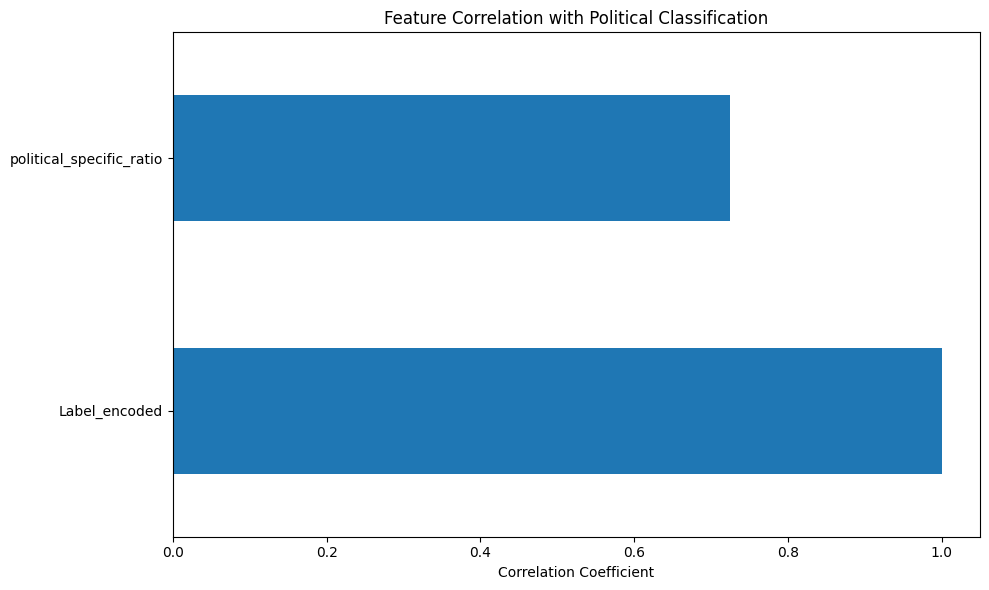

In [9]:
# Feature correlation with label
import matplotlib.pyplot as plt
import seaborn as sns

# Encode labels
train_with_features['Label_encoded'] = (train_with_features['Label'] == 'Political').astype(int)

# Calculate correlation
correlations = train_with_features[feature_columns + ['Label_encoded']].corr()['Label_encoded'].sort_values(ascending=False)

print("\n=== Feature Correlations with Political Label ===")
print(correlations)

# Visualize
plt.figure(figsize=(10, 6))
correlations[:-1].plot(kind='barh')
plt.title('Feature Correlation with Political Classification')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

# Step 3: Deep Learning Approach: mBERT for Political Meme Classification

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu



In [11]:
# Create custom dataset class
class MemeTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [13]:
# Load mBERT model and tokenizer
MODEL_NAME = "bert-base-multilingual-cased"  # Supports 104 languages including Bengali

print(f"Loading {MODEL_NAME}...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,  # Binary classification: political vs non-political
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3
    )
    print(f"Model loaded successfully!")
except Exception as e:
    print(f"Error loading from HuggingFace: {e}")
    print("\nTrying to load from cache...")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, local_files_only=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3,
        local_files_only=True
    )
    print(f"Model loaded from cache!")

model = model.to(device)
print(f"Model ready on {device}!")

Loading bert-base-multilingual-cased...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model ready on cpu!


In [14]:
# Prepare data - Split train into train and validation
X_train_texts = train_df['Processed_Text'].values
# Convert labels to numeric: Political=1, NonPolitical=0
y_train_labels = (train_df['Label'] == 'Political').astype(int).values

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_texts, 
    y_train_labels, 
    test_size=0.15, 
    random_state=42,
    stratify=y_train_labels
)

print(f"Training samples: {len(X_train_split)}")
print(f"Validation samples: {len(X_val_split)}")
print(f"Test samples: {len(test_df)}")
print(f"\nClass distribution in training:")
print(f"Non-political: {(y_train_split == 0).sum()}")
print(f"Political: {(y_train_split == 1).sum()}")

Training samples: 2431
Validation samples: 429
Test samples: 330

Class distribution in training:
Non-political: 1706
Political: 725


In [15]:
# Create datasets and dataloaders
MAX_LENGTH = 128  # Maximum sequence length
BATCH_SIZE = 16   # Adjust based on GPU memory

train_dataset = MemeTextDataset(X_train_split, y_train_split, tokenizer, MAX_LENGTH)
val_dataset = MemeTextDataset(X_val_split, y_val_split, tokenizer, MAX_LENGTH)
test_dataset = MemeTextDataset(
    test_df['Processed_Text'].values, 
    np.zeros(len(test_df)),  # Dummy labels for test
    tokenizer, 
    MAX_LENGTH
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 152
Validation batches: 27
Test batches: 21


In [16]:
# Debug: Check data types and values
print("Checking label data types...")
print(f"y_train_split type: {type(y_train_split[0])}, dtype: {y_train_split.dtype}")
print(f"y_val_split type: {type(y_val_split[0])}, dtype: {y_val_split.dtype}")
print(f"Sample y_train_split values: {y_train_split[:5]}")
print(f"Unique values in y_train_split: {np.unique(y_train_split)}")
print(f"\nChecking text data...")
print(f"X_train_split[0]: {X_train_split[0][:100]}...")
print(f"Type: {type(X_train_split[0])}")

Checking label data types...
y_train_split type: <class 'numpy.int64'>, dtype: int64
y_val_split type: <class 'numpy.int64'>, dtype: int64
Sample y_train_split values: [0 0 0 0 1]
Unique values in y_train_split: [0 1]

Checking text data...
X_train_split[0]: আটী ময়দী সুজি কাঁদী, ময়লী এবং নৌংরা পানি...
Type: <class 'str'>


In [17]:
# Setup optimizer and scheduler
EPOCHS = 7
LEARNING_RATE = 1e-5
WARMUP_STEPS = 100

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")

Total training steps: 1064
Warmup steps: 100


In [18]:
# Training function
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    progress_bar = tqdm(data_loader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        preds = torch.argmax(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        progress_bar.set_postfix({'loss': loss.item(), 'acc': correct_predictions/total_samples})
    
    return total_loss / len(data_loader), correct_predictions / total_samples

In [19]:
# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    avg_loss = total_loss / len(data_loader)
    
    return avg_loss, accuracy, predictions, true_labels

In [20]:
# Training loop
best_val_accuracy = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    print(f'\n{"="*50}')
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'{"="*50}')
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f'\nTrain Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = eval_model(model, val_loader, device)
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_mbert_model.pth')
        print(f'✓ Best model saved! (Val Accuracy: {val_acc:.4f})')
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(val_labels, val_preds, target_names=['Non-Political', 'Political']))

print(f'\n{"="*50}')
print(f'Training completed!')
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')
print(f'{"="*50}')


Epoch 1/7


Training:   0%|          | 0/152 [00:00<?, ?it/s]

Training: 100%|██████████| 152/152 [23:29<00:00,  9.27s/it, loss=0.504, acc=0.706]



Train Loss: 0.5838, Train Accuracy: 0.7063


Evaluating: 100%|██████████| 27/27 [00:46<00:00,  1.71s/it]



Val Loss: 0.4645, Val Accuracy: 0.7879
✓ Best model saved! (Val Accuracy: 0.7879)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.78      0.97      0.87       301
    Political       0.85      0.35      0.50       128

     accuracy                           0.79       429
    macro avg       0.81      0.66      0.68       429
 weighted avg       0.80      0.79      0.76       429


Epoch 2/7
✓ Best model saved! (Val Accuracy: 0.7879)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.78      0.97      0.87       301
    Political       0.85      0.35      0.50       128

     accuracy                           0.79       429
    macro avg       0.81      0.66      0.68       429
 weighted avg       0.80      0.79      0.76       429


Epoch 2/7


Training: 100%|██████████| 152/152 [18:41<00:00,  7.38s/it, loss=0.429, acc=0.814]




Train Loss: 0.4335, Train Accuracy: 0.8137


Evaluating: 100%|██████████| 27/27 [00:43<00:00,  1.60s/it]



Val Loss: 0.3980, Val Accuracy: 0.8415
✓ Best model saved! (Val Accuracy: 0.8415)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.82      0.99      0.90       301
    Political       0.97      0.48      0.65       128

     accuracy                           0.84       429
    macro avg       0.89      0.74      0.77       429
 weighted avg       0.86      0.84      0.82       429


Epoch 3/7
✓ Best model saved! (Val Accuracy: 0.8415)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.82      0.99      0.90       301
    Political       0.97      0.48      0.65       128

     accuracy                           0.84       429
    macro avg       0.89      0.74      0.77       429
 weighted avg       0.86      0.84      0.82       429


Epoch 3/7


Training: 100%|██████████| 152/152 [19:35<00:00,  7.73s/it, loss=0.29, acc=0.84] 



Train Loss: 0.3872, Train Accuracy: 0.8404


Evaluating: 100%|██████████| 27/27 [00:47<00:00,  1.74s/it]



Val Loss: 0.3382, Val Accuracy: 0.8578
✓ Best model saved! (Val Accuracy: 0.8578)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.84      0.98      0.91       301
    Political       0.91      0.58      0.71       128

     accuracy                           0.86       429
    macro avg       0.88      0.78      0.81       429
 weighted avg       0.87      0.86      0.85       429


Epoch 4/7
✓ Best model saved! (Val Accuracy: 0.8578)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.84      0.98      0.91       301
    Political       0.91      0.58      0.71       128

     accuracy                           0.86       429
    macro avg       0.88      0.78      0.81       429
 weighted avg       0.87      0.86      0.85       429


Epoch 4/7


Training: 100%|██████████| 152/152 [20:33<00:00,  8.11s/it, loss=0.58, acc=0.863] 



Train Loss: 0.3431, Train Accuracy: 0.8626


Evaluating: 100%|██████████| 27/27 [00:50<00:00,  1.85s/it]



Val Loss: 0.3117, Val Accuracy: 0.8834
✓ Best model saved! (Val Accuracy: 0.8834)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.88      0.97      0.92       301
    Political       0.91      0.68      0.78       128

     accuracy                           0.88       429
    macro avg       0.89      0.82      0.85       429
 weighted avg       0.89      0.88      0.88       429


Epoch 5/7
✓ Best model saved! (Val Accuracy: 0.8834)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.88      0.97      0.92       301
    Political       0.91      0.68      0.78       128

     accuracy                           0.88       429
    macro avg       0.89      0.82      0.85       429
 weighted avg       0.89      0.88      0.88       429


Epoch 5/7


Training: 100%|██████████| 152/152 [20:46<00:00,  8.20s/it, loss=0.733, acc=0.873]



Train Loss: 0.3068, Train Accuracy: 0.8733


Evaluating: 100%|██████████| 27/27 [00:54<00:00,  2.03s/it]



Val Loss: 0.3510, Val Accuracy: 0.8601

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.84      0.99      0.91       301
    Political       0.97      0.55      0.70       128

     accuracy                           0.86       429
    macro avg       0.90      0.77      0.80       429
 weighted avg       0.88      0.86      0.85       429


Epoch 6/7


Training: 100%|██████████| 152/152 [20:03<00:00,  7.92s/it, loss=0.35, acc=0.881]  




Train Loss: 0.2927, Train Accuracy: 0.8811


Evaluating: 100%|██████████| 27/27 [00:44<00:00,  1.66s/it]



Val Loss: 0.3044, Val Accuracy: 0.8858
✓ Best model saved! (Val Accuracy: 0.8858)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.87      0.98      0.92       301
    Political       0.94      0.66      0.77       128

     accuracy                           0.89       429
    macro avg       0.91      0.82      0.85       429
 weighted avg       0.89      0.89      0.88       429


Epoch 7/7
✓ Best model saved! (Val Accuracy: 0.8858)

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.87      0.98      0.92       301
    Political       0.94      0.66      0.77       128

     accuracy                           0.89       429
    macro avg       0.91      0.82      0.85       429
 weighted avg       0.89      0.89      0.88       429


Epoch 7/7


Training: 100%|██████████| 152/152 [19:50<00:00,  7.83s/it, loss=0.309, acc=0.896]



Train Loss: 0.2658, Train Accuracy: 0.8955


Evaluating: 100%|██████████| 27/27 [00:57<00:00,  2.13s/it]

Val Loss: 0.3035, Val Accuracy: 0.8811

Classification Report:
               precision    recall  f1-score   support

Non-Political       0.87      0.98      0.92       301
    Political       0.93      0.65      0.76       128

     accuracy                           0.88       429
    macro avg       0.90      0.81      0.84       429
 weighted avg       0.89      0.88      0.87       429


Training completed!
Best Validation Accuracy: 0.8858


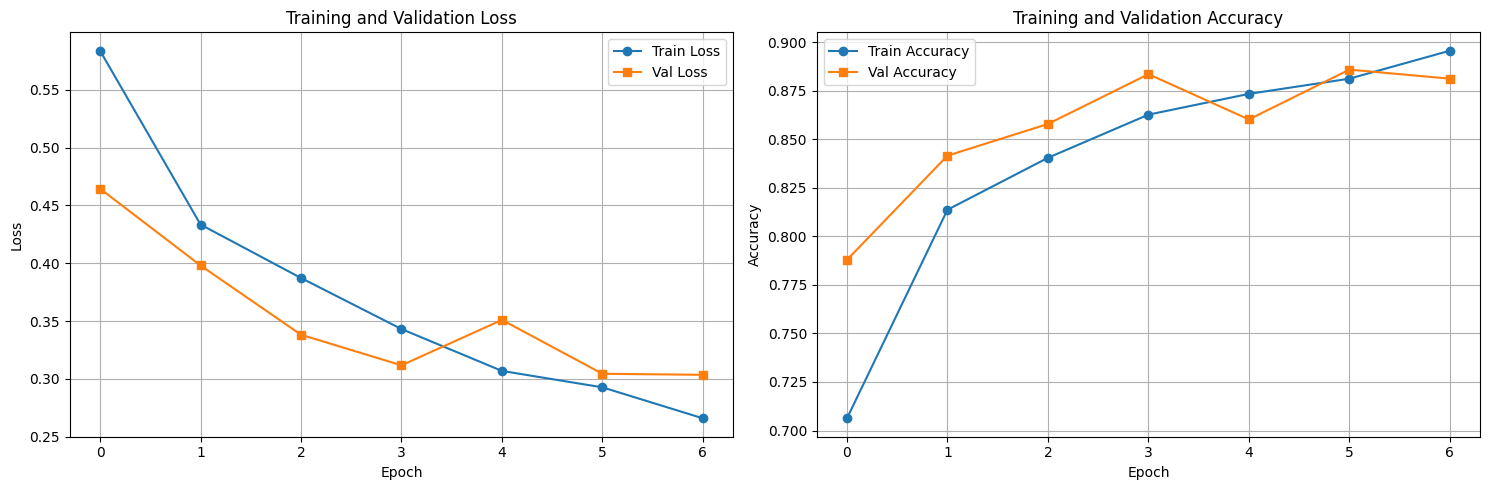

In [21]:
# Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Val Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Load best model and make predictions on test set
model.load_state_dict(torch.load('best_mbert_model.pth'))
print("Best model loaded!")

# Predict on test data
model.eval()
test_predictions = []
test_probabilities = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Predicting on test set'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        test_predictions.extend(preds.cpu().numpy())
        test_probabilities.extend(probs.cpu().numpy())

test_predictions = np.array(test_predictions)
test_probabilities = np.array(test_probabilities)

print(f"\nTest predictions generated!")
print(f"Political memes: {(test_predictions == 1).sum()}")
print(f"Non-political memes: {(test_predictions == 0).sum()}")

Best model loaded!


Predicting on test set: 100%|██████████| 21/21 [00:36<00:00,  1.74s/it]


Test predictions generated!
Political memes: 94
Non-political memes: 236


In [23]:
# Create submission file
submission_mbert = pd.DataFrame({
    'Image_name': test_df['Image_name'],
    'Label': ['Political' if pred == 1 else 'NonPolitical' for pred in test_predictions]
})

submission_mbert.to_csv('submission_mbert.csv', index=False)
print("Submission file saved as 'submission_mbert.csv'")
print("\nFirst 10 predictions:")
print(submission_mbert.head(10))

Submission file saved as 'submission_mbert.csv'

First 10 predictions:
     Image_name         Label
0  test0001.jpg  NonPolitical
1  test0002.jpg  NonPolitical
2  test0003.jpg  NonPolitical
3  test0004.jpg     Political
4  test0005.jpg  NonPolitical
5  test0006.jpg  NonPolitical
6  test0007.jpg  NonPolitical
7  test0008.jpg  NonPolitical
8  test0009.jpg  NonPolitical
9  test0010.jpg  NonPolitical
